In [1]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

Configure Logger

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import Trainer
import torch 
import numpy as np 
from src.keypoint_utils import gaussian_heatmap, generate_keypoints_heatmap, get_keypoints_from_heatmap
from src.models import KeypointDetector
from src.datamodule import BoxKeypointsDataModule, BoxKeypointsDataset


In [4]:

wandb_logger = WandbLogger(project="test-project", entity="airo-box-manipulation")

In [5]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


In [6]:
torch.cuda.is_available()

False

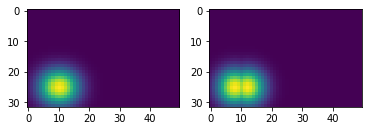

In [7]:
## Demonstration on why one should use max(.) instead of sum to combine the keypoints
# sum wil make 1 blob of 2 neighbouring keypoints
# furthermore it will also reduce the 
img = gaussian_heatmap((32,50),(8,25),torch.Tensor([4]))
img2 = gaussian_heatmap((32,50),(12,25),torch.Tensor([4]))

f, axarr = plt.subplots(1,2)
axarr[0].imshow(img  +img2)
axarr[1].imshow(torch.max(img, img2))

In [8]:
IMAGE_DATASET_PATH = "/workspaces/box-manipulation/datasets/box_dataset2"
JSON_PATH = "/workspaces/box-manipulation/datasets/box_dataset2/dataset.json"

In [9]:
def imshow(img):
    """
    plot Tensor as image
    images are kept in the [0,1] range, although in theory [-1,1] should be used to whiten..
    """
    np_img = img.numpy()
    # bring (C,W,H) to (W,H,C) dims
    img = np.transpose(np_img, (1,2,0))
    plt.imshow(img)
    plt.show()


In [10]:
def show_heatmap_overlay(img, heatmap):
    """
    plot Tensors of heatmap and image on same figure 
    """
    fig, ax = plt.subplots()  #create figure and axes
    img = img.numpy()
    img = np.transpose(img, (1,2,0))
    ax.imshow(img, alpha= 0.9)
    ax.imshow(heatmap.numpy(), alpha = 0.2)
    plt.show()

In [11]:


module = BoxKeypointsDataModule(BoxKeypointsDataset(JSON_PATH, IMAGE_DATASET_PATH),2)
batch = next(iter(module.train_dataloader()))
#print(batch)
print(batch[0].shape)
print(batch[1].shape)

torch.Size([2, 3, 256, 256])
torch.Size([2, 4, 2])


torch.Size([1, 2, 180, 180])
KeypointDetector(
  (validation_metric): KeypointmAPMetric()
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, dilation=(2, 2))
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, dilation=(4, 4))
    (7): LeakyReLU(negative_slope=0.01)
    (8): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, dilation=(8, 8))
    (9): LeakyReLU(negative_slope=0.01)
    (10): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, dilation=(16, 16))
    (11): LeakyReLU(negative_slope=0.01)
    (12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (13): LeakyReLU(negative_slope=0.01)
    (14): Conv2d(32, 32

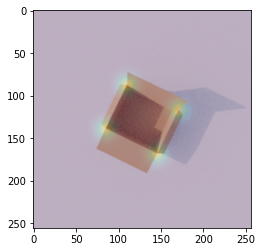

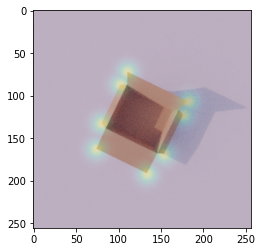

In [12]:
model = KeypointDetector(heatmap_sigma= 8)
dummy_input = torch.rand((1,3,180,180))

output = model(dummy_input)
print(output.shape)
print(model)

module = BoxKeypointsDataModule(BoxKeypointsDataset(JSON_PATH, IMAGE_DATASET_PATH),2)
batch = next(iter(module.train_dataloader()))
imgs, corner_keypoints, flap_keypoints = batch 
print(imgs[0].shape[1:])
print(imgs.shape)

heatmaps = model.create_heatmap_batch(imgs[0].shape[1:],corner_keypoints)
flap_heatmaps = model.create_heatmap_batch(imgs[0].shape[1:], flap_keypoints)
print(heatmaps.shape)
show_heatmap_overlay(imgs[0],heatmaps[0])
show_heatmap_overlay(imgs[0],flap_heatmaps[0])

In [13]:
pl.seed_everything(2021, workers = True) # deterministic run
model = KeypointDetector(detect_flap_keypoints=False)
module = BoxKeypointsDataModule(BoxKeypointsDataset(JSON_PATH, IMAGE_DATASET_PATH),2)
print(len(module.val_dataloader()))
print(len(module.train_dataloader()))
trainer = pl.Trainer(max_epochs = 2, logger=wandb_logger, gpus=0)


Global seed set to 2021
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


13
113


In [14]:
trainer.fit(model, module)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: tlips (use `wandb login --relogin` to force relogin)



  | Name              | Type              | Params
--------------------------------------------------------
0 | validation_metric | KeypointmAPMetric | 0     
1 | model             | Sequential        | 102 K 
--------------------------------------------------------
102 K     Trainable params
0         Non-trainable params
102 K     Total params
0.412     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

formatted_gt_corner_keypoints=[[Keypoint(u=115, v=156), Keypoint(u=102, v=110), Keypoint(u=140, v=99), Keypoint(u=153, v=145)], [Keypoint(u=104, v=133), Keypoint(u=125, v=103), Keypoint(u=151, v=122), Keypoint(u=130, v=152)]]


Global seed set to 2021


formatted_gt_corner_keypoints=[[Keypoint(u=163, v=118), Keypoint(u=121, v=163), Keypoint(u=92, v=137), Keypoint(u=134, v=92)], [Keypoint(u=70, v=125), Keypoint(u=131, v=70), Keypoint(u=185, v=130), Keypoint(u=124, v=185)]]


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

formatted_gt_corner_keypoints=[[Keypoint(u=115, v=156), Keypoint(u=102, v=110), Keypoint(u=140, v=99), Keypoint(u=153, v=145)], [Keypoint(u=104, v=133), Keypoint(u=125, v=103), Keypoint(u=151, v=122), Keypoint(u=130, v=152)]]
formatted_gt_corner_keypoints=[[Keypoint(u=163, v=118), Keypoint(u=121, v=163), Keypoint(u=92, v=137), Keypoint(u=134, v=92)], [Keypoint(u=70, v=125), Keypoint(u=131, v=70), Keypoint(u=185, v=130), Keypoint(u=124, v=185)]]
formatted_gt_corner_keypoints=[[Keypoint(u=151, v=115), Keypoint(u=137, v=152), Keypoint(u=104, v=140), Keypoint(u=118, v=103)], [Keypoint(u=150, v=114), Keypoint(u=137, v=152), Keypoint(u=105, v=141), Keypoint(u=118, v=103)]]
formatted_gt_corner_keypoints=[[Keypoint(u=102, v=93), Keypoint(u=168, v=114), Keypoint(u=153, v=162), Keypoint(u=87, v=141)], [Keypoint(u=96, v=105), Keypoint(u=153, v=99), Keypoint(u=159, v=150), Keypoint(u=102, v=156)]]
formatted_gt_corner_keypoints=[[Keypoint(u=111, v=93), Keypoint(u=164, v=118), Keypoint(u=144, v=162)

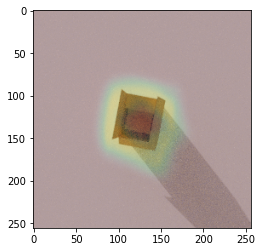

In [ ]:
batch = next(iter(module.train_dataloader()))

imgs, corner_keypoints, flap_keypoints = batch 

with torch.no_grad():
    predictions = model(imgs)
    show_heatmap_overlay(imgs[0],predictions[0][0])